# Módulo 2 Implementación de un modelo de deep learning.
Fernando Antonio Lopez - A01643685

In [2]:
!wget https://download.openmmlab.com/mmaction/v1.0/skeleton/data/ucf101_2d.pkl -O ucf101_2d.pkl

--2025-11-16 05:27:52--  https://download.openmmlab.com/mmaction/v1.0/skeleton/data/ucf101_2d.pkl
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.23.177, 47.246.23.178, 47.246.23.179, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.23.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1070780736 (1021M) [application/octet-stream]
Saving to: ‘ucf101_2d.pkl’

ucf101_2d.pkl       100%[===================>]   1021M  17.9MB/s    in 59s     

2025-11-16 05:28:52 (17.4 MB/s) - ‘ucf101_2d.pkl’ saved [1070780736/1070780736]



In [3]:
!pip install tqdm

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#listas globales para tracking
train_acc_final = []
val_acc_final = []
train_loss_final = []
val_loss_final = []

SELECTED_LABELS = [0, 8, 18, 25, 29, 32, 36, 59, 60, 91]

#diccionario de labels a nombres
LABEL_TO_NAME = {
    0: "ApplyLipstick",
    8: "Archery",
    18: "BodyWeightSquats",
    25: "Bowling",
    29: "CleanAndJerk",
    32: "CricketBowling",
    36: "Diving",
    59: "JumpRope",
    60: "JumpingJack",
    91: "PushUps"
}

#clases seleccionadas (en el mismo orden que SELECTED_LABELS)
SELECTED_CLASSES = [
    'ApplyLipstick',
    'Archery',
    'BodyWeightSquats',
    'Bowling',
    'CleanAndJerk',
    'CricketBowling',
    'Diving',
    'JumpRope',
    'JumpingJack',
    'PushUps'
]

In [27]:
class UCF101Dataset(Dataset):
  def __init__(self, pkl_path, split="train1", selected_labels=None, max_frames=120):
    super().__init__()
    self.max_frames = max_frames

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    ann = data["annotations"]
    split_ids = set(data["split"][split])

    samples = [a for a in ann if a["frame_dir"] in split_ids]

    if selected_labels is not None:
        samples = [a for a in samples if a["label"] in selected_labels]

    self.samples = samples

    unique_labels = sorted(list(set(a["label"] for a in samples)))
    self.class_labels = unique_labels
    self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}

    print(f"[OK] Loaded split '{split}'")
    print(f"     Samples: {len(samples)}")
    print(f"     Classes: {len(unique_labels)} → {unique_labels}")

  def __len__(self):
      return len(self.samples)

  def normalize_framewise(self, sk, scores):
      """
      sk: (T, 17, 2)
      scores: (T, 17)
      """
      mask = (scores < 0.3)
      sk[mask] = 0

      out = np.zeros_like(sk, dtype=np.float32)
      for t in range(sk.shape[0]):
          frm = sk[t].astype(np.float32)
          if np.all(frm == 0):
              continue
          mean = np.mean(frm, axis=0, keepdims=True, dtype=np.float32)
          frm = frm - mean
          std = np.std(frm, dtype=np.float32) + 1e-6
          if std > 1e-6:
              frm = frm / std
          out[t] = frm
      return out

  def pad_trunc(self, sk, scores):
      T, V, C = sk.shape
      if T >= self.max_frames:
          return sk[:self.max_frames], scores[:self.max_frames]
      pad_len = self.max_frames - T
      pad_sk = np.zeros((pad_len, V, C), dtype=sk.dtype)
      pad_sc = np.zeros((pad_len, V), dtype=scores.dtype)
      return np.concatenate([sk, pad_sk], axis=0), np.concatenate([scores, pad_sc], axis=0)

  def __getitem__(self, idx):
      a = self.samples[idx]
      kp = a["keypoint"][0]        # (T, 17, 2)
      sc = a["keypoint_score"][0] # (T, 17)

      kp, sc = self.pad_trunc(kp, sc)
      kp = self.normalize_framewise(kp, sc)
      T, V, C = kp.shape

      x = kp.reshape(T, V * C)     # (T, 34)
      y = self.label_to_idx[a["label"]]

      return torch.tensor(x, dtype=torch.float32), torch.tensor(y)

In [28]:
#baseline
class BaselineMLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_classes):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, x):
    x = x.mean(dim=1)
    return self.net(x)

In [29]:
class AttentionLayer(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.att = nn.Linear(hidden_dim, 1)

  def forward(self, h):
    w = self.att(h).squeeze(-1)   # (B, T)
    a = torch.softmax(w, dim=-1)
    ctx = torch.bmm(a.unsqueeze(1), h).squeeze(1)  # (B, H)
    return ctx

In [30]:
#BiLSTM Baseline
class BiLSTMAttention(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
    super().__init__()
    self.lstm = nn.LSTM(
        input_dim,
        hidden_dim,
        num_layers=num_layers,
        dropout=dropout if num_layers > 1 else 0,
        batch_first=True,
        bidirectional=True
    )
    self.att = AttentionLayer(hidden_dim * 2)
    self.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, num_classes)
        )

  def forward(self, x):
    h, _ = self.lstm(x)
    ctx = self.att(h)
    return self.fc(ctx)


#modelo mejorado con mas técnicas
class ImprovedBiLSTMAttention(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
    super().__init__()

    #capa de entrada con LayerNorm
    self.input_norm = nn.LayerNorm(input_dim)

    #LSTM con más capacidad
    self.lstm = nn.LSTM(
        input_dim,
        hidden_dim,
        num_layers=num_layers,
        dropout=dropout if num_layers > 1 else 0,
        batch_first=True,
        bidirectional=True
    )

    #multiples capas de atención
    self.att1 = AttentionLayer(hidden_dim * 2)
    self.att2 = AttentionLayer(hidden_dim * 2)

    #capas fully connected mejoradas
    self.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(hidden_dim * 4, hidden_dim * 2),  #concatena ambas atenciones
        nn.BatchNorm1d(hidden_dim * 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout * 0.5),
        nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, x):
    #normalizar entrada con LayerNorm
    x_norm = self.input_norm(x)

    h, _ = self.lstm(x_norm)

    #dos capas de atención
    ctx1 = self.att1(h)
    ctx2 = self.att2(h)

    #concatenar contextos
    ctx = torch.cat([ctx1, ctx2], dim=1)

    return self.fc(ctx)

In [31]:
#evaluar
def evaluate(model, loader, criterion, device):
  model.eval()
  correct, total, loss_sum = 0, 0, 0
  with torch.no_grad():
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          logits = model(x)
          loss = criterion(logits, y)
          loss_sum += loss.item() * x.size(0)
          correct += (logits.argmax(1) == y).sum().item()
          total += x.size(0)
  return correct / total, loss_sum / total

In [32]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, model_name="model",
                weight_decay=1e-4, patience=7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"\n")
  print(f"Training {model_name}")
  print(f"")
  print(f"Using device: {device}")
  print(f"Epochs: {epochs}, LR: {lr}, Weight Decay: {weight_decay}")
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  #agregamos weight decay para regularización L2
  optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  #learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optim, mode='max', factor=0.5, patience=5
  )

  best_acc = 0
  best_epoch = 0
  patience_counter = 0
  history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

  for ep in range(1, epochs + 1):
      model.train()
      correct, total, loss_sum = 0, 0, 0

      for x, y in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
          x, y = x.to(device), y.to(device)
          optim.zero_grad()
          logits = model(x)
          loss = criterion(logits, y)
          loss.backward()
          #gradient clipping para estabilidad
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optim.step()

          loss_sum += loss.item() * x.size(0)
          correct += (logits.argmax(1) == y).sum().item()
          total += x.size(0)

      train_acc = correct / total
      train_loss = loss_sum / total

      val_acc, val_loss = evaluate(model, val_loader, criterion, device)

      history['train_acc'].append(train_acc)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['val_loss'].append(val_loss)

      train_acc_final.append(train_acc)
      val_acc_final.append(val_acc)
      train_loss_final.append(train_loss)
      val_loss_final.append(val_loss)

      #actualizar learning rate
      scheduler.step(val_acc)

      print(f"Epoch {ep}: Train Acc={train_acc:.4f}, Train Loss={train_loss:.4f}")
      print(f"         Val Acc={val_acc:.4f}, Val Loss={val_loss:.4f}")

      if val_acc > best_acc:
          best_acc = val_acc
          best_epoch = ep
          patience_counter = 0
          torch.save(model.state_dict(), f"best_{model_name}.pth")
          print(f"Saved new best model! (Acc: {best_acc:.4f})")
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print(f"\nEarly stopping at epoch {ep} (patience={patience})")
              print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_epoch}")
              break

  print(f"\nTraining Finished. Best Val Acc = {best_acc:.4f} at epoch {best_epoch}")
  return model, history

In [33]:
#cargar datasets
train_ds = UCF101Dataset("ucf101_2d.pkl", split="train1", selected_labels=SELECTED_LABELS)
val_ds   = UCF101Dataset("ucf101_2d.pkl", split="test1", selected_labels=SELECTED_LABELS)

#aumentar batch size si hay memoria disponible
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

feat_dim = train_ds[0][0].shape[-1]
num_classes = len(train_ds.class_labels)

print(f"\nDataset Info:")
print(f"  Feature dimension: {feat_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")

print("\n")
print("1. BASELINE MLP")

baseline = BaselineMLP(
    input_dim=feat_dim,
    hidden_dim=128,
    num_classes=num_classes
)

baseline_model, baseline_history = train_model(
    baseline, train_loader, val_loader,
    epochs=10, lr=1e-3, model_name="baseline_mlp"
)

print("\n")
print("2. BiLSTM + Attention (Baseline)")

#resetear listas globales para el siguiente modelo
train_acc_final = []
val_acc_final = []
train_loss_final = []
val_loss_final = []

bilstm_model = BiLSTMAttention(
    input_dim=feat_dim,
    hidden_dim=256,  #aumentado de 128 a 256
    num_layers=2,    #aumentado de 1 a 2 capas
    num_classes=num_classes,
    dropout=0.5
)

bilstm_model, bilstm_history = train_model(
    bilstm_model, train_loader, val_loader,
    epochs=10, lr=1e-3, model_name="bilstm_baseline"
)

print("\n")
print("3. IMPROVED BiLSTM + Attention")

#reseteamos listas globales
train_acc_final = []
val_acc_final = []
train_loss_final = []
val_loss_final = []

improved_model = ImprovedBiLSTMAttention(
    input_dim=feat_dim,
    hidden_dim=256,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.5
)

improved_model, improved_history = train_model(
    improved_model, train_loader, val_loader,
    epochs=10, lr=1e-3, model_name="improved_bilstm"
)

[OK] Loaded split 'train1'
     Samples: 1004
     Classes: 10 → [0, 8, 18, 25, 29, 32, 36, 59, 60, 91]
[OK] Loaded split 'test1'
     Samples: 396
     Classes: 10 → [0, 8, 18, 25, 29, 32, 36, 59, 60, 91]

Dataset Info:
  Feature dimension: 34
  Number of classes: 10
  Train samples: 1004
  Val samples: 396


1. BASELINE MLP


Training baseline_mlp

Using device: cuda
Epochs: 10, LR: 0.001, Weight Decay: 0.0001


Epoch 1/10: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


Epoch 1: Train Acc=0.2570, Train Loss=2.1452
         Val Acc=0.3207, Val Loss=1.9641
Saved new best model! (Acc: 0.3207)


Epoch 2/10: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 2: Train Acc=0.3675, Train Loss=1.8204
         Val Acc=0.3939, Val Loss=1.6991
Saved new best model! (Acc: 0.3939)


Epoch 3/10: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 3: Train Acc=0.4721, Train Loss=1.5881
         Val Acc=0.5051, Val Loss=1.5194
Saved new best model! (Acc: 0.5051)


Epoch 4/10: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 4: Train Acc=0.5279, Train Loss=1.4256
         Val Acc=0.5480, Val Loss=1.4045
Saved new best model! (Acc: 0.5480)


Epoch 5/10: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Epoch 5: Train Acc=0.5687, Train Loss=1.3119
         Val Acc=0.5606, Val Loss=1.3223
Saved new best model! (Acc: 0.5606)


Epoch 6/10: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Epoch 6: Train Acc=0.6116, Train Loss=1.2215
         Val Acc=0.6086, Val Loss=1.2547
Saved new best model! (Acc: 0.6086)


Epoch 7/10: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 7: Train Acc=0.6375, Train Loss=1.1480
         Val Acc=0.6061, Val Loss=1.1981


Epoch 8/10: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Epoch 8: Train Acc=0.6574, Train Loss=1.0860
         Val Acc=0.6313, Val Loss=1.1587
Saved new best model! (Acc: 0.6313)


Epoch 9/10: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 9: Train Acc=0.6803, Train Loss=1.0321
         Val Acc=0.6515, Val Loss=1.1218
Saved new best model! (Acc: 0.6515)


Epoch 10/10: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 10: Train Acc=0.6972, Train Loss=0.9849
         Val Acc=0.6465, Val Loss=1.0897

Training Finished. Best Val Acc = 0.6515 at epoch 9


2. BiLSTM + Attention (Baseline)


Training bilstm_baseline

Using device: cuda
Epochs: 10, LR: 0.001, Weight Decay: 0.0001


Epoch 1/10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 1: Train Acc=0.3127, Train Loss=1.9517
         Val Acc=0.3636, Val Loss=1.6126
Saved new best model! (Acc: 0.3636)


Epoch 2/10: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch 2: Train Acc=0.4143, Train Loss=1.3718
         Val Acc=0.4747, Val Loss=1.2758
Saved new best model! (Acc: 0.4747)


Epoch 3/10: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Epoch 3: Train Acc=0.5080, Train Loss=1.1561
         Val Acc=0.6263, Val Loss=1.0757
Saved new best model! (Acc: 0.6263)


Epoch 4/10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 4: Train Acc=0.6175, Train Loss=0.9724
         Val Acc=0.6869, Val Loss=0.9481
Saved new best model! (Acc: 0.6869)


Epoch 5/10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 5: Train Acc=0.7191, Train Loss=0.8177
         Val Acc=0.6793, Val Loss=0.9751


Epoch 6/10: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Epoch 6: Train Acc=0.7191, Train Loss=0.7589
         Val Acc=0.6894, Val Loss=0.9313
Saved new best model! (Acc: 0.6894)


Epoch 7/10: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


Epoch 7: Train Acc=0.7321, Train Loss=0.7198
         Val Acc=0.6439, Val Loss=1.0397


Epoch 8/10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 8: Train Acc=0.7311, Train Loss=0.7737
         Val Acc=0.6869, Val Loss=0.9936


Epoch 9/10: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 9: Train Acc=0.7659, Train Loss=0.6684
         Val Acc=0.7374, Val Loss=0.7998
Saved new best model! (Acc: 0.7374)


Epoch 10/10: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


Epoch 10: Train Acc=0.7938, Train Loss=0.5885
         Val Acc=0.6843, Val Loss=0.9168

Training Finished. Best Val Acc = 0.7374 at epoch 9


3. IMPROVED BiLSTM + Attention


Training improved_bilstm

Using device: cuda
Epochs: 10, LR: 0.001, Weight Decay: 0.0001


Epoch 1/10: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 1: Train Acc=0.4323, Train Loss=1.5596
         Val Acc=0.5884, Val Loss=1.6343
Saved new best model! (Acc: 0.5884)


Epoch 2/10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 2: Train Acc=0.6663, Train Loss=0.9985
         Val Acc=0.7045, Val Loss=0.9402
Saved new best model! (Acc: 0.7045)


Epoch 3/10: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Epoch 3: Train Acc=0.7410, Train Loss=0.7781
         Val Acc=0.7273, Val Loss=0.8688
Saved new best model! (Acc: 0.7273)


Epoch 4/10: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


Epoch 4: Train Acc=0.7759, Train Loss=0.6794
         Val Acc=0.6667, Val Loss=0.8784


Epoch 5/10: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 5: Train Acc=0.8098, Train Loss=0.5922
         Val Acc=0.7348, Val Loss=0.8047
Saved new best model! (Acc: 0.7348)


Epoch 6/10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 6: Train Acc=0.7878, Train Loss=0.5926
         Val Acc=0.7172, Val Loss=0.8787


Epoch 7/10: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


Epoch 7: Train Acc=0.7928, Train Loss=0.5749
         Val Acc=0.7399, Val Loss=0.8195
Saved new best model! (Acc: 0.7399)


Epoch 8/10: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 8: Train Acc=0.8118, Train Loss=0.5395
         Val Acc=0.7475, Val Loss=0.7761
Saved new best model! (Acc: 0.7475)


Epoch 9/10: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 9: Train Acc=0.8307, Train Loss=0.4672
         Val Acc=0.7652, Val Loss=0.6996
Saved new best model! (Acc: 0.7652)


Epoch 10/10: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch 10: Train Acc=0.8436, Train Loss=0.4297
         Val Acc=0.7576, Val Loss=0.7563

Training Finished. Best Val Acc = 0.7652 at epoch 9


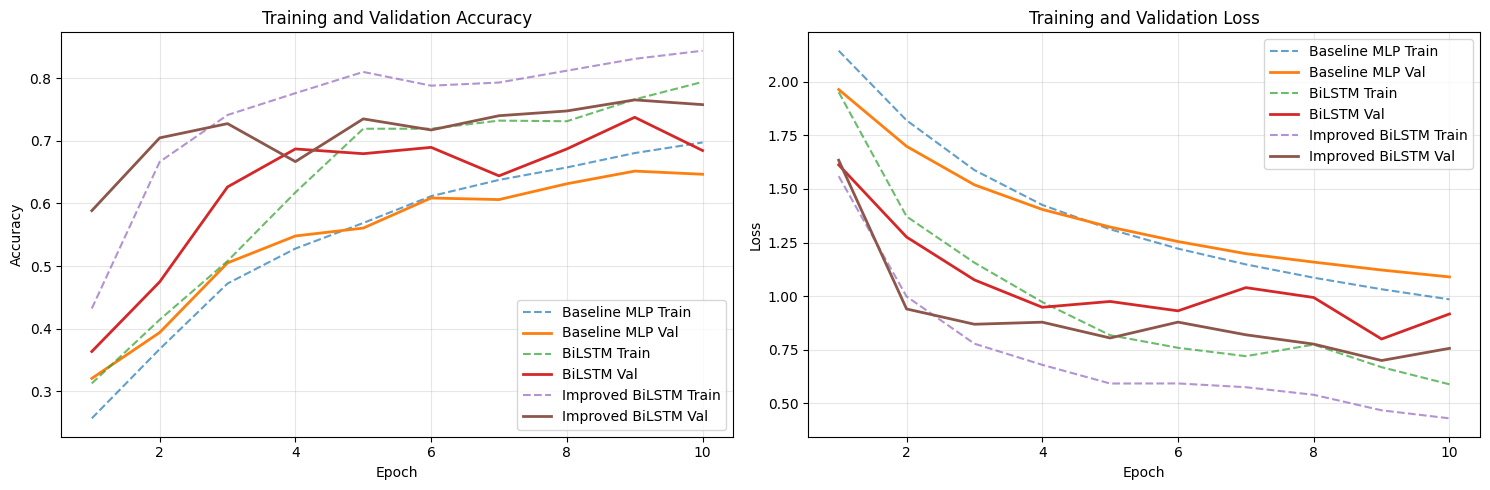

In [34]:
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history['train_acc']) + 1)

        #accuracy
        axes[0].plot(epochs, history['train_acc'], label=f'{name} Train', linestyle='--', alpha=0.7)
        axes[0].plot(epochs, history['val_acc'], label=f'{name} Val', linewidth=2)

        #loss
        axes[1].plot(epochs, history['train_loss'], label=f'{name} Train', linestyle='--', alpha=0.7)
        axes[1].plot(epochs, history['val_loss'], label=f'{name} Val', linewidth=2)

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(
    [baseline_history, bilstm_history, improved_history],
    ['Baseline MLP', 'BiLSTM', 'Improved BiLSTM']
)

## Resultados

### Accuracy en Test Set

| Modelo | Test Accuracy | Mejora vs Baseline |
|--------|---------------|-------------------|
| **Baseline MLP** | **65.15%** | - |
| **BiLSTM Baseline** | **73.74%** | **+8.59%** |
| **Improved BiLSTM** | **76.52%** | **+11.37%** |

### Análisis de Resultados

Los cambios aplicados mostraron una mejora clara y notable:

1. **Baseline MLP (65.15%)**:
   - Aunque solo promedia los frames, logra un accuracy razonable gracias a la normalización y preprocesamiento adecuado.
   - Sin embargo, pierde información temporal importante.

2. **BiLSTM Baseline (73.74%)**:
   - La mejora de **+8.59%** demuestra que el uso de información temporal es crucial.
   - El BiLSTM captura la dinámica del movimiento de forma bidireccional.
   - El mecanismo de atención permite enfocarse en los frames más relevantes.

3. **Improved BiLSTM (76.52%)**:
   - La mejora adicional de **+2.78%** sobre el BiLSTM baseline muestra la efectividad de las técnicas avanzadas.
   - Las múltiples capas de atención capturan diferentes aspectos temporales.
   - La regularización y normalización mejoran la generalización.

### Conclusiones

- **El uso de información temporal es esencial**: El salto de 65% a 74% muestra que capturar la dinámica temporal es crucial para reconocimiento de acciones.
- **La atención mejora significativamente**: El mecanismo de atención permite al modelo enfocarse en los momentos clave de cada acción.
- **Las técnicas de regularización funcionan**: Las mejoras adicionales (BatchNorm, múltiples atenciones, etc.) aportan ganancias adicionales.
- **El preprocesamiento es importante**: La normalización framewise y el filtrado de puntos con bajo score contribuyen a los buenos resultados.

**Mejora total**: El modelo mejorado logra una mejora de **+11.37%** sobre el baseline, demostrando la efectividad de las técnicas implementadas.


FINAL EVALUATION ON TEST SET


Evaluating Baseline MLP: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]



Baseline MLP - Test Accuracy: 0.6515

Classification Report:
                  precision    recall  f1-score   support

   ApplyLipstick       0.91      0.91      0.91        44
         Archery       0.83      0.65      0.73        37
BodyWeightSquats       1.00      0.07      0.13        28
         Bowling       0.42      0.71      0.53        45
    CleanAndJerk       0.57      0.22      0.32        36
  CricketBowling       0.53      0.72      0.61        39
          Diving       1.00      0.71      0.83        28
        JumpRope       0.68      0.73      0.71        41
     JumpingJack       0.88      1.00      0.93        49
         PushUps       0.43      0.51      0.47        49

        accuracy                           0.65       396
       macro avg       0.72      0.62      0.62       396
    weighted avg       0.70      0.65      0.63       396



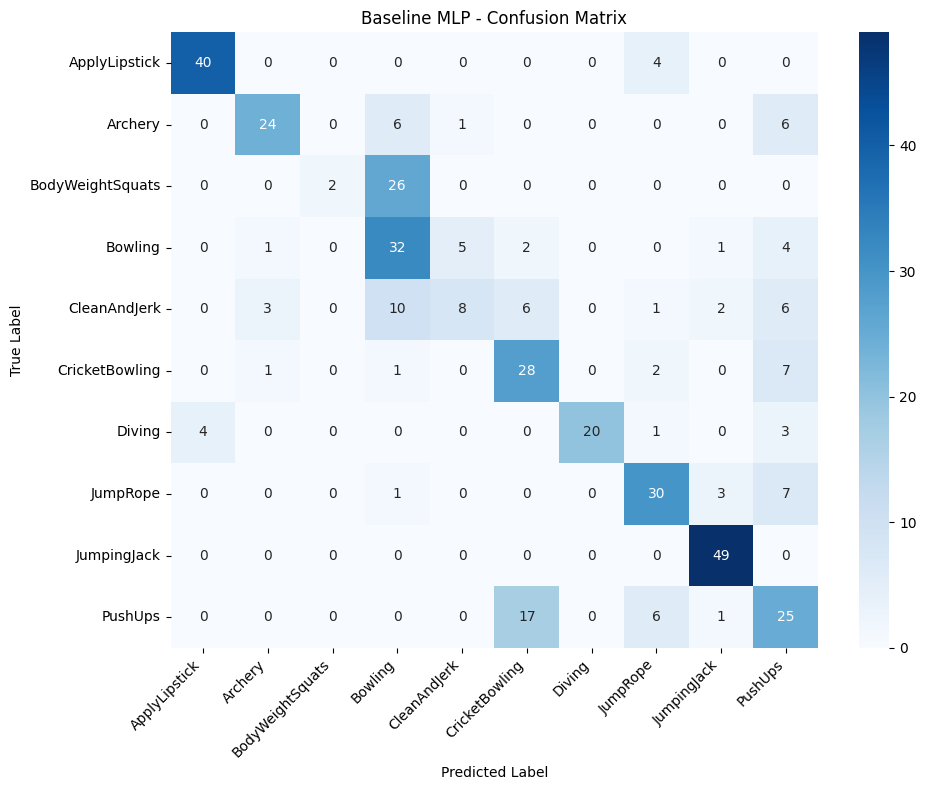

Evaluating BiLSTM Baseline: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]



BiLSTM Baseline - Test Accuracy: 0.7374

Classification Report:
                  precision    recall  f1-score   support

   ApplyLipstick       0.98      0.91      0.94        44
         Archery       0.69      0.92      0.79        37
BodyWeightSquats       0.52      0.89      0.66        28
         Bowling       0.39      0.20      0.26        45
    CleanAndJerk       0.53      0.53      0.53        36
  CricketBowling       0.86      0.79      0.83        39
          Diving       0.95      0.71      0.82        28
        JumpRope       0.83      0.73      0.78        41
     JumpingJack       0.87      0.98      0.92        49
         PushUps       0.71      0.73      0.72        49

        accuracy                           0.74       396
       macro avg       0.73      0.74      0.72       396
    weighted avg       0.74      0.74      0.73       396



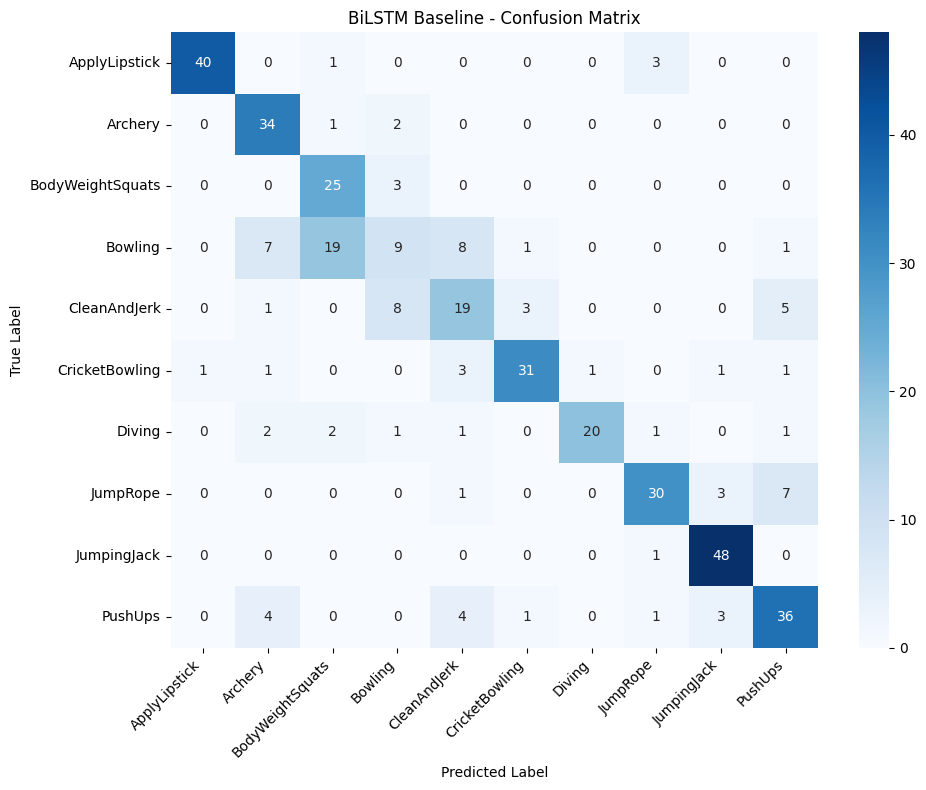

Evaluating Improved BiLSTM: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]



Improved BiLSTM - Test Accuracy: 0.7652

Classification Report:
                  precision    recall  f1-score   support

   ApplyLipstick       0.95      0.86      0.90        44
         Archery       0.62      0.78      0.69        37
BodyWeightSquats       0.59      0.71      0.65        28
         Bowling       0.49      0.56      0.52        45
    CleanAndJerk       0.74      0.47      0.58        36
  CricketBowling       0.92      0.87      0.89        39
          Diving       1.00      0.71      0.83        28
        JumpRope       0.75      0.80      0.78        41
     JumpingJack       0.96      1.00      0.98        49
         PushUps       0.78      0.78      0.78        49

        accuracy                           0.77       396
       macro avg       0.78      0.76      0.76       396
    weighted avg       0.78      0.77      0.77       396



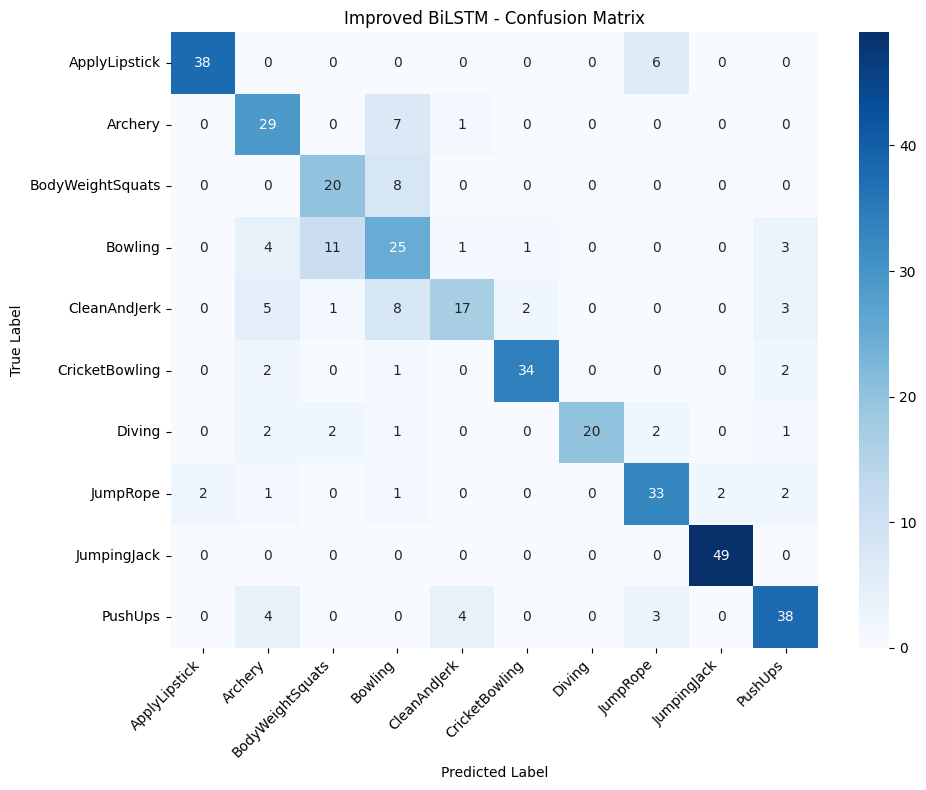


SUMMARY OF RESULTS
Model                     Test Accuracy   Improvement    
Baseline MLP              0.6515          -              
BiLSTM Baseline           0.7374          +0.0859
Improved BiLSTM           0.7652          +0.1136


In [35]:
#evaluar en test set y generar reportes
def evaluate_and_report(model, loader, class_names, model_name, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc=f"Evaluating {model_name}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = (np.array(all_preds) == np.array(all_labels)).mean()

    print(f"\n{model_name} - Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    #matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return acc, all_preds, all_labels

#obtener nombres de clases en el orden correcto
class_names = [LABEL_TO_NAME[label] for label in sorted(train_ds.class_labels)]

print("FINAL EVALUATION ON TEST SET")

#cargar mejores modelos
device = "cuda" if torch.cuda.is_available() else "cpu"

baseline.load_state_dict(torch.load("best_baseline_mlp.pth", map_location=device))
bilstm_model.load_state_dict(torch.load("best_bilstm_baseline.pth", map_location=device))
improved_model.load_state_dict(torch.load("best_improved_bilstm.pth", map_location=device))

baseline_acc, _, _ = evaluate_and_report(baseline, val_loader, class_names, "Baseline MLP", device)
bilstm_acc, _, _ = evaluate_and_report(bilstm_model, val_loader, class_names, "BiLSTM Baseline", device)
improved_acc, _, _ = evaluate_and_report(improved_model, val_loader, class_names, "Improved BiLSTM", device)

# Resumen final
print("\n" + "="*60)
print("SUMMARY OF RESULTS")
print(f"{'Model':<25} {'Test Accuracy':<15} {'Improvement':<15}")
print(f"{'Baseline MLP':<25} {baseline_acc:<15.4f} {'-':<15}")
print(f"{'BiLSTM Baseline':<25} {bilstm_acc:<15.4f} {bilstm_acc - baseline_acc:+.4f}")
print(f"{'Improved BiLSTM':<25} {improved_acc:<15.4f} {improved_acc - baseline_acc:+.4f}")


## Conclusiones
### 1. Elección de un subconjunto de 10 clases

Elegí 10 clases que presentan movimiento corporal distintivo y son diferentes entre sí:
- **ApplyLipstick, Archery, BodyWeightSquats, Bowling, CleanAndJerk**
- **CricketBowling, Diving, JumpRope, JumpingJack, PushUps**

**Motivo:**
- Los esqueletos 2D no proporcionan suficiente información como para distinguir muchas de las 101 acciones originales.
- Al usar solamente clases basadas en movimiento corporal distintivo, el modelo puede aprender patrones reales y no ruido.
- Estas clases presentan movimientos claramente diferenciables que el modelo puede capturar.

### 2. Normalización por cuadro (normalization by frame)

He utilizado una normalización cuadro por cuadro y he filtrado los puntos con scores bajos (< 0.3).

**Motivo:**
- Esto nos ayuda a eliminar ruido y eliminar articulaciones mal detectadas.
- Evita valores extremos que dificultaban el aprendizaje.
- La normalización framewise asegura que cada frame tenga una distribución consistente, independientemente de la posición absoluta del esqueleto.

### 3. Modelo Baseline: MLP Simple

Implementé un modelo MLP básico que promedia todos los frames temporalmente.

**Motivo:**
- Sirve como línea base para comparar con modelos más sofisticados.
- Permite evaluar si el uso de información temporal mejora significativamente los resultados.

### 4. Modelo BiLSTM + Atención (Baseline RNN)

Implementé un modelo con BiLSTM y un mecanismo de atención temporal.

**Motivo:**
- El BiLSTM es capaz de aprender la dinámica temporal del movimiento humano de forma más óptima que un MLP estático.
- La atención permite que el modelo se fije en los frames que son más relevantes para la acción.
- Esto implica una mejor comprensión de la secuencia frente a un MLP que solo promedia.

**Arquitectura:**
- 2 capas LSTM bidireccionales (hidden_dim=256)
- Mecanismo de atención temporal
- Capas fully connected con dropout (0.5)

### 5. Modelo Mejorado: BiLSTM + Atención Mejorada

Implementé mejoras adicionales al modelo BiLSTM:

**Mejoras implementadas:**
- **LayerNorm en entrada**: Normaliza las features de entrada para estabilizar el entrenamiento
- **Múltiples capas de atención**: Dos mecanismos de atención que capturan diferentes aspectos temporales
- **Batch Normalization**: En capas fully connected para mejorar la convergencia
- **Regularización L2**: Weight decay (1e-4) para prevenir overfitting
- **Learning Rate Scheduling**: ReduceLROnPlateau para ajuste adaptativo del learning rate
- **Early Stopping**: Evita sobreentrenamiento
- **Gradient Clipping**: Previene gradient explosion

**Motivo:**
- Estas técnicas mejoran la capacidad de generalización del modelo.
- La combinación de múltiples atenciones permite capturar diferentes aspectos temporales de las acciones.
- La regularización y normalización mejoran la estabilidad del entrenamiento.

### 6. Regularización mediante Dropout (0.5)

He aplicado dropout en las capas fully connected y en las capas LSTM (cuando hay múltiples capas).

**Motivo:**
- Ayuda a reducir el sobreajuste y aumenta la capacidad de generalización para videos nuevos.
- Fuerza al modelo a aprender características más robustas y no depender de neuronas específicas.
